In [8]:
import warnings
warnings.filterwarnings("ignore")
from numpy import asarray
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from PIL import Image
import cv2
import glob
import os
import random
import subprocess
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.patches import Rectangle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os


In [9]:
import zipfile

zip_path = "/content/archive.zip"  # Replace with the actual filename

# Extract the contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/driver_monitoring")  # Extract to a folder

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [10]:
import os
dataset_path = "/content/driver_monitoring"

# Check extracted contents
print("Extracted files:", os.listdir(dataset_path))


Extracted files: ['valid', 'train', 'data.yaml', 'test']


In [11]:
import yaml

yaml_path = "/content/driver_monitoring/data.yaml"  # Update the path if necessary

with open(yaml_path, 'r') as file:
    data_info = yaml.safe_load(file)

print("Dataset Information:")
print(data_info)


Dataset Information:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 5, 'names': ['Open Eye', 'Closed Eye', 'Cigarette', 'Phone', 'Seatbelt']}


In [12]:
train_path = '/content/driver_monitoring/train/images'
test_path  = '/content/driver_monitoring/test/images'
valid_path = '/content/driver_monitoring/valid/images'

In [13]:
train = os.listdir(train_path)
test=os.listdir(test_path)
valid=os.listdir(valid_path)

In [14]:
font = {'family':'Times New Roman','color':'#1f211f'}
background_color = '#fab72f'

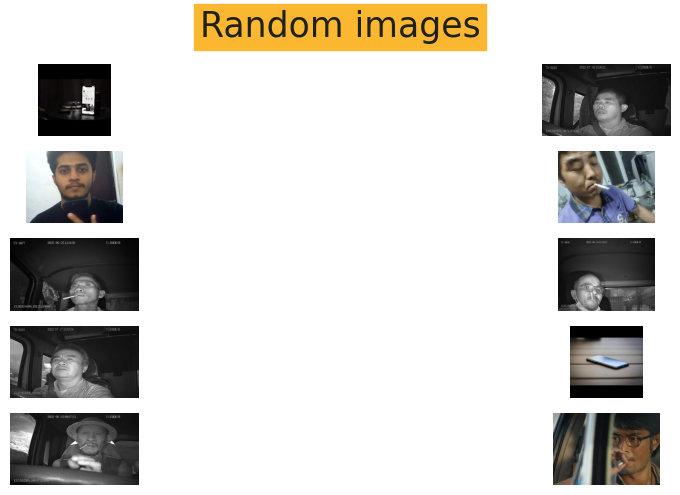

In [15]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(5, 2, i+1)
    img_name = random.choice(train)
    img_path = os.path.join(train_path, img_name)
    img = imread(img_path)

    plt.imshow(img)
    plt.axis('off')  # Turn off axis for each subplot

plt.suptitle("Random images",
             fontdict=font, fontsize=25, backgroundcolor=background_color)
plt.tight_layout()
plt.show()

In [16]:
import os
from collections import defaultdict

def parse_txt_annotation(annotation_path, class_id_map=None):
    """
    Enhanced parser for YOLO-style annotations with better error handling
    Returns list of labels with class names from CLASS_ID_MAP
    """
    labels = []

    try:
        with open(annotation_path, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
    except FileNotFoundError:
        print(f"Warning: Annotation file not found {annotation_path}")
        return []

    for line_number, line in enumerate(lines, 1):
        if not line:
            continue  # Skip empty lines

        parts = line.split()

        # Validate line format
        if len(parts) < 5:
            print(f"Warning: Invalid annotation in {os.path.basename(annotation_path)} line {line_number}: '{line}'")
            continue

        class_id = parts[0]

        # Validate class ID format
        try:
            class_id = int(class_id)
        except ValueError:
            print(f"Error: Invalid class ID in {os.path.basename(annotation_path)} line {line_number}: '{class_id}'")
            continue

        # Map to class name
        if class_id_map:
            label = class_id_map.get(class_id, f"unknown_{class_id}")
        else:
            label = str(class_id)

        labels.append(label)

    return labels

def get_image_labels(images_dir, annotations_dir, class_id_map=None):
    """
    Map images to their labels from text annotations
    Returns dictionary mapping image filenames to their labels
    """
    image_labels = defaultdict(list)
    supported_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')

    for image_file in os.listdir(images_dir):
        if not image_file.lower().endswith(supported_exts):
            continue

        base_name = os.path.splitext(image_file)[0]
        ann_file = os.path.join(annotations_dir, f"{base_name}.txt")

        if not os.path.exists(ann_file):
            print(f"Warning: Missing annotation for {image_file}")
            continue

        labels = parse_txt_annotation(ann_file, class_id_map)
        if labels:
            # Remove duplicate labels while preserving order
            seen = set()
            unique_labels = [l for l in labels if not (l in seen or seen.add(l))]
            image_labels[image_file] = unique_labels
        else:
            print(f"Warning: No valid labels found for {image_file}")

    return image_labels

In [17]:
TEST_IMAGES_DIR = '/content/driver_monitoring/test/images'
TEST_ANNOTATIONS_DIR = '/content/driver_monitoring/test/labels'

TRAIN_IMAGES_DIR = '/content/driver_monitoring/train/images'
TRAIN_ANNOTATIONS_DIR = '/content/driver_monitoring/train/labels'

VALID_IMAGES_DIR = '/content/driver_monitoring/valid/images'
VALID_ANNOTATIONS_DIR = '/content/driver_monitoring/valid/labels'

CLASS_ID_MAP = {
    0: 'Open Eye',
    1: 'Closed Eye',
    2: 'Cigarette',
    3: 'Phone',
    4: 'Seatbelt'
}

# Get labels
train_label_mapping = get_image_labels(TRAIN_IMAGES_DIR, TRAIN_ANNOTATIONS_DIR, CLASS_ID_MAP)
test_label_mapping = get_image_labels(TEST_IMAGES_DIR, TEST_ANNOTATIONS_DIR, CLASS_ID_MAP)
valid_label_mapping = get_image_labels(VALID_IMAGES_DIR, VALID_ANNOTATIONS_DIR, CLASS_ID_MAP)

In [18]:
train_df = pd.DataFrame([(k, ', '.join(v)) for k, v in train_label_mapping.items()],
                  columns=['filename', 'labels'])
test_df = pd.DataFrame([(k, ', '.join(v)) for k, v in test_label_mapping.items()],
                  columns=['filename', 'labels'])
valid_df = pd.DataFrame([(k, ', '.join(v)) for k, v in valid_label_mapping.items()],
                  columns=['filename', 'labels'])

In [19]:
all_classes = list(CLASS_ID_MAP.values())

for class_name in all_classes:
    train_df[class_name] = train_df['labels'].apply(lambda x: 1 if class_name in x else 0)
    test_df[class_name] = test_df['labels'].apply(lambda x: 1 if class_name in x else 0)
    valid_df[class_name] = valid_df['labels'].apply(lambda x: 1 if class_name in x else 0)

In [20]:
train_df['filepath'] = TRAIN_IMAGES_DIR + '/' + train_df['filename']
test_df['filepath'] = TEST_IMAGES_DIR + '/' + test_df['filename']
valid_df['filepath'] = VALID_IMAGES_DIR + '/' + valid_df['filename']

In [21]:
all_classes


['Open Eye', 'Closed Eye', 'Cigarette', 'Phone', 'Seatbelt']

In [22]:
IMG_SIZE = (240, 240)
BATCH_SIZE = 32

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col=all_classes,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

Found 5957 validated image filenames.


In [24]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col=all_classes,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

Found 2389 validated image filenames.


In [25]:
def AlexNet():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(96, 11, 4, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Conv2D(256, 5, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Conv2D(384, 3, 1, activation='relu')(x)
    x = layers.Conv2D(384, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='sigmoid')(x)

    model_Alex = models.Model(inputs=inp, outputs=x)

    return model_Alex
model_Alex = AlexNet()
model_Alex.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 58, 58, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 58, 58, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │          20,485 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,748,805 (94.41 MB)

 Trainable params: 24,748,101 (94.41 MB)

 Non-trainable params: 704 (2.75 KB)

In [26]:
callbacks = [
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_freq='epoch',  # Save only at the end of each epoch
        verbose=1  # Set to 1 for progress information
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1  # Set to 1 for termination messages
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1  # Set to 1 for LR reduction messages
    )
]

In [27]:
# Compile the model
model_Alex.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['binary_accuracy']
)

In [30]:
# Fit the model
history = model_Alex.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,  # Train for 200 epochs
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_steps=len(valid_df) // BATCH_SIZE,
    #callbacks=callbacks,
    verbose=1  # Display progress for every epoch
)

Epoch 1/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 89s 464ms/step - binary_accuracy: 0.8151 - loss: 0.4001 - val_binary_accuracy: 0.8030 - val_loss: 0.4093
Epoch 2/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 152us/step - binary_accuracy: 0.8375 - loss: 0.3620 - val_binary_accuracy: 0.7619 - val_loss: 0.4436
Epoch 3/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 88s 451ms/step - binary_accuracy: 0.8234 - loss: 0.3736 - val_binary_accuracy: 0.7864 - val_loss: 0.4816
Epoch 4/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - binary_accuracy: 0.8313 - loss: 0.3472 - val_binary_accuracy: 0.8476 - val_loss: 0.3171
Epoch 5/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 89s 460ms/step - binary_accuracy: 0.8292 - loss: 0.3646 - val_binary_accuracy: 0.7646 - val_loss: 0.4765
Epoch 6/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step - binary_accuracy: 0.7937 - loss: 0.4119 - val_binary_accuracy: 0.7524 - val_loss: 0.4759
Epoch 7/200
186/186 ━━━━━━━━━━━━━━━━━━━━ 142s 462ms/step - binary_accuracy: 0.8305 - loss: 0.3620 - val_binary_accuracy: 0.7335 

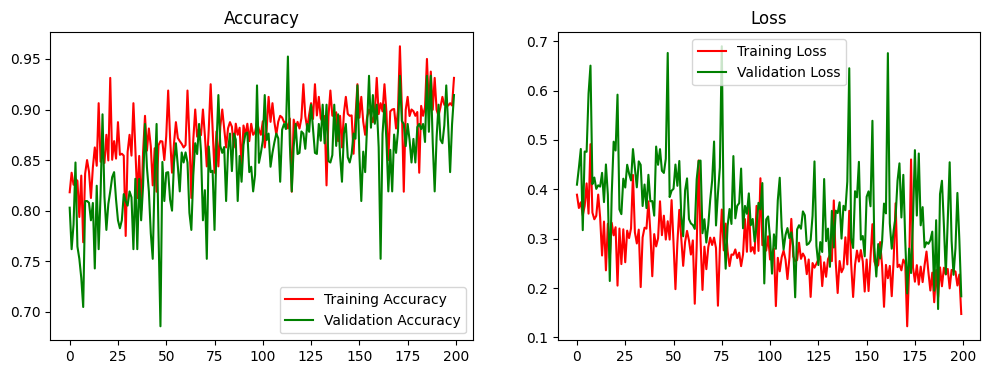

In [40]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy', color='red')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy', color='green')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)



In [42]:
# Get the highest training accuracy and the lowest training loss
max_train_accuracy = max(history.history['binary_accuracy'])
min_train_loss = min(history.history['loss'])



max_val_accuracy = max(history.history['val_binary_accuracy'])
min_val_loss = min(history.history['val_loss'])
print("Training Accuracy:", max_train_accuracy)
print("Validation Accuracy:", max_val_accuracy)

print("Training Loss:", min_train_loss)
print("Validation Loss:", min_val_loss)


Training Accuracy: 0.9624999761581421
Validation Accuracy: 0.9523809552192688
Training Loss: 0.12244507670402527
Validation Loss: 0.1574111431837082


In [32]:
model_Alex.save("model_alexnet.h5")
